In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
from os import listdir
from os.path import isfile, join

In [5]:
#!git clone https://github.com/Marinku099/Sci-project-m5.git

In [6]:
# not sure the real size
width = 450
hieght = 550

In [7]:
PATH = r"D:/Jiw/work/01-school-Work/01-classroom-Work/02-SciProj/Sci-project-m5/data/cdi-data-scan1266.xlsx"
df = pd.read_excel(PATH, sheet_name=r"depressed-data")
#df = df[["ID","Pt","DEP","Age","Sex"]] #1 = depressed

In [8]:
PATH

'D:/Jiw/work/01-school-Work/01-classroom-Work/02-SciProj/Sci-project-m5/data/cdi-data-scan1266.xlsx'

In [9]:
def labelfeatures(ID):
    i = df['Pt'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    score = df.loc[i[0], ["Pt","Age","Sex"]]
    score.to_numpy()
    return score

In [10]:
def labelY(ID):
    i = df['DEP'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    y = df.loc[i[0], "DEP"]
    return y

In [30]:
def img2data(path):
  img_data = []
  DEP = []

  IDs = []
  features = []

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for item in tqdm(os.listdir(folder_path)):
      filePath = os.path.join(folder_path, item)

      # print(item)
      ID = int(item.split('.')[0])
      DEP.append(labelY(ID))

      IDs.append(ID)
      features.append(labelfeatures(ID))
      

      img = cv2.imread(filePath, cv2.IMREAD_COLOR)
      # plt.imshow(img)
      img = cv2.resize(img , (224, 224))
      # img.append(score)
      #img = np.reshape(img, (224, 224, 3))

      img_data.append(img)

  return img_data, DEP, IDs, features

In [31]:
img,Y, img_name, features,  = img2data(r"D:\Jiw\work\01-school-Work\01-classroom-Work\02-SciProj\Sci-project-m5\data_label")
#flattened_images = img.reshape(img.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(img, Y, random_state=0, train_size=.8)
# print(img)

100%|██████████| 280/280 [00:02<00:00, 104.04it/s]


In [32]:
num_class = 2

#Polishing data

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = to_categorical(y_train, num_classes=num_class)
y_test = to_categorical(y_test, num_classes=num_class)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255



x_train.shape, x_test.shape, y_train.shape, y_test.shape

((372, 224, 224, 3), (94, 224, 224, 3), (372, 2), (94, 2))

In [33]:
from keras.applications import vgg16
img_rows, img_col = 224,224

vgg = vgg16.VGG16(weights='imagenet',
                  include_top= False,
                  input_shape=(img_rows,img_col,3)
                  )

for layer in vgg.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [34]:
def lw(bottom_model, num_class):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_class,activation='softmax')(top_model)
    return top_model

In [35]:
from keras.models import Model

FC_heaed = lw(vgg, num_class)
model = Model(inputs = vgg.input, outputs = FC_heaed)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit(x_train,y_train,
                    epochs=18,
                    validation_data=(x_test,y_test),
                    verbose=1,
                    initial_epoch=0)

Epoch 1/18
12/12 [==============================] - 61s 5s/step - loss: 0.8387 - accuracy: 0.5242 - val_loss: 0.7088 - val_accuracy: 0.4043
Epoch 2/18
12/12 [==============================] - 62s 5s/step - loss: 0.7082 - accuracy: 0.5161 - val_loss: 0.6761 - val_accuracy: 0.5957
Epoch 3/18
12/12 [==============================] - 62s 5s/step - loss: 0.6853 - accuracy: 0.6022 - val_loss: 0.6755 - val_accuracy: 0.5957
Epoch 4/18
12/12 [==============================] - 63s 5s/step - loss: 0.6822 - accuracy: 0.6022 - val_loss: 0.6770 - val_accuracy: 0.5957
Epoch 5/18
12/12 [==============================] - 62s 5s/step - loss: 0.6735 - accuracy: 0.6022 - val_loss: 0.6776 - val_accuracy: 0.5957
Epoch 6/18
12/12 [==============================] - 66s 6s/step - loss: 0.6743 - accuracy: 0.6022 - val_loss: 0.6838 - val_accuracy: 0.6064
Epoch 7/18
12/12 [==============================] - 61s 5s/step - loss: 0.6758 - accuracy: 0.6048 - val_loss: 0.6766 - val_accuracy: 0.5957
Epoch 8/18
12/12 [==

3/3 - 11s - loss: 0.6866 - accuracy: 0.5532 - 11s/epoch - 4s/step


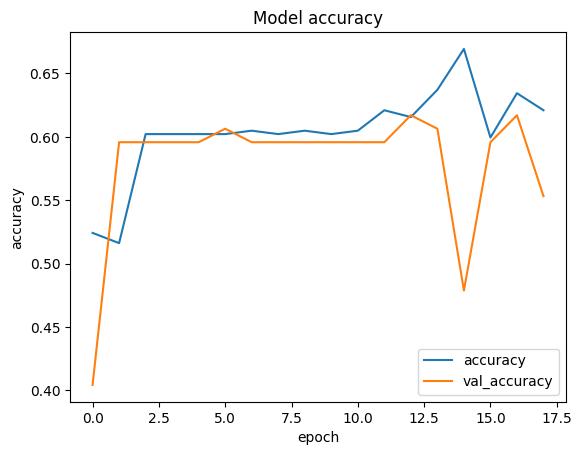

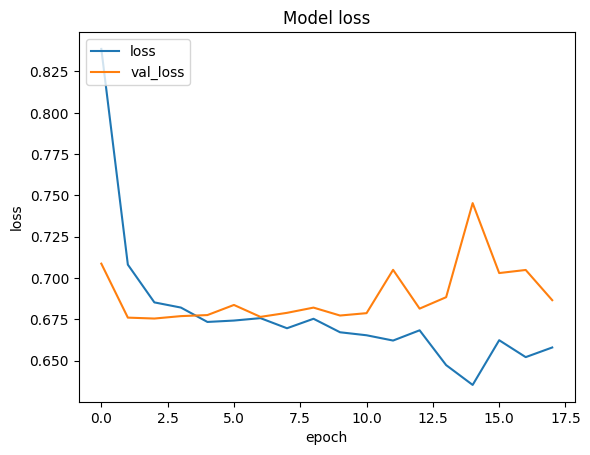

In [47]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['accuracy','val_accuracy'],loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.show()
# "LOSS"

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [51]:
y_pred = model.predict(x_test)

3/3 [==============================] - 11s 4s/step


In [52]:
pd.DataFrame(y_pred)

,0,1
0,0.565925,0.434075
1,0.539085,0.460915
2,0.468242,0.531757
3,0.604183,0.395817
4,0.494245,0.505754
...,...,...
89,0.559734,0.440266
90,0.563389,0.436611
91,0.627295,0.372705
92,0.433714,0.566286


In [53]:
# Assuming you have already trained your model and have x_test and y_test
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
#y_test = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels
Y_train = np.argmax(y_test, axis=1)

In [55]:
print(adjusted_mutual_info_score(Y_train, y_pred))
print(f1_score(Y_train, y_pred))
print(accuracy_score(Y_train, y_pred))

-0.009198221045716071
0.22222222222222218
0.5531914893617021


In [56]:
y_pred

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0], dtype=int64)

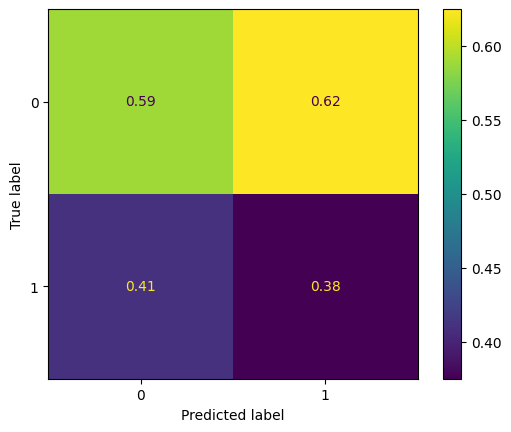

In [58]:
result = confusion_matrix(Y_train, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result)
    
disp.plot()
plt.show()

In [59]:
rimg = []
testPath = r"data_label"

for imgPath in (testPath):
    for item in (os.listdir(testPath)):
        file = os.path.join(testPath, item)
        if item.split('.')[0] != "":
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img
            img = cv2.resize(img , (width, hieght))

            rimg = np.array(img)
            rimg = rimg.astype('float32')

            predict = model.predict(rimg)
            label = ['DEP','un DEP']
            result = label[int(predict)]
            print('real:' + str(item))
            print('predict' + str(result))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_label'